# **Part 1: Improved Dynamic Topic Modeling of Trump’s Tweets with BERTopic**
In this project, we perform topic modeling on the Trump tweets dataset, which is the same dataset mentioned in the paper. However, we follow the different approaches for each steps. Instead of using general-purpose embeddings, we use the **BERTweet embedding model**, which is specifically designed for English tweets.
This notebook covers the following **main steps**:

1. **Data Loading and Pre-processing:** The Twitter dataset contains noisy and unstructured text, so preprocessing is required to get the better results.


2. **Static Topic Modeling with BERTweet:**
We apply BERTopic using the BERTweet embedding model.

3. **Dynamic Topic Modeling:**
We analyze how topic frequencies change over time to understand temporal trends in discussions.

4. **Classical Topic Modeling with LDA:**
We apply LDA as a traditional topic modeling baseline.

5. **Evaluation and Comparison:**
We compare the results of BERTopic and LDA using topic coherence and topic diversity metrics.

## **Step 1: Data Loading and Pre processing**

In [1]:
!pip install panda bertopic
!pip install gensim
!pip install tweet-preprocessor bertopic sentence-transformers
!pip3 install emoji==0.6.0

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.1 MB/s eta 0:00:00
  Created wheel for panda: filename=panda-0.3.1-py3-none-any.whl size=7239 sha256=c2c0ab6a4f1cd19c7b756ce50ff842403180e5c9865722c76115afe4df682d41
  Stored in directory: /root/.cache/pip/wheels/98/41/5b/6ca54e0b6a35e1b7248c12f56fcb753dfb7717fefaa0fb45f5
Successfully built panda
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49719 sha256=366a9ae0ad8618483f8da748dea5c18692fe04104140b75faca8ee1cc02d2108
  Stored in directory: /root/.cache/pip/wheels/0d/bf/a2/536017b4a6232aef0fb92831af35facd6590c0af0f3983f63b
Successfully built emoji


In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import preprocessor as p

import re
import pandas as pd
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import bertopic
import logging
import preprocessor as p
from nltk.corpus import stopwords
import nltk
print(bertopic.__version__)

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


0.17.4


In [3]:
df = pd.read_csv("/content/tweets_01-08-2021.csv")
print("Columns in dataset:")
print(df.columns.tolist())
print("\nDataset info:")
print(df.info())

Columns in dataset:
['id', 'text', 'isRetweet', 'isDeleted', 'device', 'favorites', 'retweets', 'date', 'isFlagged']

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56571 entries, 0 to 56570
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         56571 non-null  int64 
 1   text       56571 non-null  object
 2   isRetweet  56571 non-null  object
 3   isDeleted  56571 non-null  object
 4   device     56571 non-null  object
 5   favorites  56571 non-null  int64 
 6   retweets   56571 non-null  int64 
 7   date       56571 non-null  object
 8   isFlagged  56571 non-null  object
dtypes: int64(3), object(6)
memory usage: 3.9+ MB
None


In [68]:
print("Sample:")
df.head()

Sample:


,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
0,98454970654916608,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,2011-08-02 18:07:48,f
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,f
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17 03:22:47,f
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58,f
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17 13:13:59,f


According to the paper, retweets should be removed. In the dataset, "isRetweet" == "f" indicates original tweets. Therefore, retweets were excluded so that only original tweets were analyzed.

In [69]:
df = df[df["isRetweet"] == "f"].reset_index(drop=True)

print(f"Number of original tweets: {len(df)}")

Number of original tweets: 46694


The tweet dates were converted to a standard datetime format, invalid entries were removed, and the tweets were sorted in the order of time. The final dataset spans from the earliest to the latest tweet and includes a total of all valid tweets, with example tweets shown for inspection.

In [70]:
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"])
df = df.sort_values("date").reset_index(drop=True)


start_date = df["date"].min()
end_date = df["date"].max()

print(f"Total number of tweets: {len(df)}")
print(f"Date range: {start_date.date()} → {end_date.date()}")

print("\nExample tweets:")
for i in range(3):
    print(f"- {df.loc[i, 'text']}")

Total number of tweets: 46694
Date range: 2009-05-04 → 2021-01-08

Example tweets:
- Be sure to tune in and watch Donald Trump on Late Night with David Letterman as he presents the Top Ten List tonight!
- Donald Trump will be appearing on The View tomorrow morning to discuss Celebrity Apprentice and his new book Think Like A Champion!
- Donald Trump reads Top Ten Financial Tips on Late Show with David Letterman: http://tinyurl.com/ooafwn - Very funny!


Tweet text was lightly preprocessed by converting all text to lowercase, removing URLs, user mentions, emojis, non-alphabetic characters, and extra whitespace. Tweets that became empty after preprocessing were removed. The cleaned tweet texts and their corresponding timestamps were then extracted for use in topic modeling.

In [71]:
def preprocess_tweet(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    #remove emojis-unicode ranges
    text = re.sub(
        "["
        "\U0001F600-\U0001F64F"  #emoticons
        "\U0001F300-\U0001F5FF"  #symbols & pictographs
        "\U0001F680-\U0001F6FF"  #transport & map symbols
        "\U0001F700-\U0001F77F"
        "\U0001F780-\U0001F7FF"
        "\U0001F800-\U0001F8FF"
        "\U0001F900-\U0001F9FF"
        "\U0001FA00-\U0001FAFF"
        "\U00002702-\U000027B0"
        "\U000024C2-\U0001F251"
        "]+",
        "",
        text
    )

    text = re.sub(r"\d+", "", text)  #remove numbers
    text = text.replace("#", "") #keep hashtag words, remove only "#"
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    text = " ".join(text.split())
    return text

In [72]:
df["clean_text"] = df["text"].apply(preprocess_tweet)
df = df[df["clean_text"] != ""].reset_index(drop=True)
df = df[df["clean_text"].str.split().str.len() >= 3].reset_index(drop=True)
print(f"Number of tweets after preprocessing: {len(df)}")
df[["text", "clean_text"]].head()

Number of tweets after preprocessing: 43234


,text,clean_text
0,Be sure to tune in and watch Donald Trump on L...,be sure to tune in and watch donald trump on l...
1,Donald Trump will be appearing on The View tom...,donald trump will be appearing on the view tom...
2,Donald Trump reads Top Ten Financial Tips on L...,donald trump reads top ten financial tips on l...
3,New Blog Post: Celebrity Apprentice Finale and...,new blog post celebrity apprentice finale and ...
4,"""""""My persona will never be that of a wallflow...",my persona will never be that of a wallflower ...


In [73]:
tweets = df["clean_text"].tolist()
timestamps = df["date"].tolist()

In [ ]:
# print(timestamps)

## **Step 2: Static topic modeling with BertTweet**

**BERTweet is not a topic modeling algorithm itself but serves as a domain-specific embedding model within the BERTopic topic modeling framework.**

BERTweet is the first publicly available LLM pre-trained specifically on English Twitter data. It follows the RoBERTa pre-training strategy, which improves upon the original BERT architecture through optimized training procedures such as dynamic masking and the removal of the next-sentence prediction objective.


https://github.com/VinAIResearch/BERTweet#introduction


In [74]:
nltk.download('stopwords')

stop_words = stopwords.words("english")
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s',
    level=logging.INFO
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [75]:
#bertweet setup
vectorizer_model = CountVectorizer(stop_words=stop_words)
topic_model_bertweet = BERTopic(embedding_model="vinai/bertweet-base",
                       vectorizer_model=vectorizer_model,
                       low_memory=True,
                       calculate_probabilities=True,
                       verbose=True, n_gram_range=(1, 3))

In [76]:
topics_bertweet, probs_bertweet = topic_model_bertweet.fit_transform(tweets)

2026-01-02 18:53:50,560 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/1352 [00:00<?, ?it/s]

2026-01-02 18:55:06,746 - BERTopic - Embedding - Completed ✓
2026-01-02 18:55:06,747 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-02 18:55:50,882 - BERTopic - Dimensionality - Completed ✓
2026-01-02 18:55:50,884 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-02 19:00:26,841 - BERTopic - Cluster - Completed ✓
2026-01-02 19:00:26,861 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-02 19:00:27,868 - BERTopic - Representation - Completed ✓


In [77]:
topic_info = topic_model_bertweet.get_topic_info()
topic_info_clean = topic_info[topic_info["Topic"] != -1]
topic_info_sorted = topic_info_clean.sort_values(
    by="Count",
    ascending=False

)

topic_info_sorted.head(10)

,Topic,Count,Name,Representation,Representative_Docs
1,0,2153,0_fbi_collusion_mueller_fake,"[fbi, collusion, mueller, fake, hunt, witch, c...",[robert mueller is being asked to testify yet ...
2,1,1572,1_run_please_president_need,"[run, please, president, need, needs, mr, vote...","[so can u run please be our president, please ..."
3,2,1007,2_entrepreneurs_think_focus_success,"[entrepreneurs, think, focus, success, champio...","[keep your focus and never give up, entreprene..."
4,3,575,3_stewart_dumb_ratings_magazine,"[stewart, dumb, ratings, magazine, show, jon, ...",[magazine is doing so poorly that they make ev...
5,4,545,4_thank_thanks_inspiration_nice,"[thank, thanks, inspiration, nice, birthday, w...","[thank you for all you do thank you, you sir a..."
6,5,538,5_makeamericagreatagain_thank_votetrump_trump,"[makeamericagreatagain, thank, votetrump, trum...","[thank you amp makeamericagreatagain, thank yo..."
7,6,453,6_via_donald_trump_talks,"[via, donald, trump, talks, tea, cpac, exclusi...","[via donald trump to speak at cpac by, via by ..."
8,7,407,7_market_stock_unemployment_jobs,"[market, stock, unemployment, jobs, record, hi...",[consumer confidence is at an all time high al...
9,8,351,8_obamacare_repeal_premiums_website,"[obamacare, repeal, premiums, website, healthc...",[remember when you vote obamacare is a disaste...
10,9,313,9_albert_einstein_winston_churchill,"[albert, einstein, winston, churchill, lombard...",[success is not final failure is not fatal it ...


### Auto Topic Labeling

Each time the code was run, the topic IDs changed, also the values. Therefore, we applied automatic labeling to make it easier to understand what each topic represents.

In [78]:
def get_top_keywords(topic_model_bertweet, topic_id, top_n=10):
    words = topic_model_bertweet.get_topic(topic_id)
    if words is None:
        return []
    return [w for w, _ in words[:top_n]]

def format_topic_name(parts):
    return "" + ", ".join(parts)
topic_info_readable = topic_info_sorted.copy()

topic_info_readable["Words"] = topic_info_readable["Topic"].apply(
    lambda t: format_topic_name(get_top_keywords(topic_model_bertweet, t, top_n=10)) #showing 10 words in a row instead of default 5 words
)

In [79]:
label_rules = {
    "election": "Presidential Campaign & Elections",
    "vote": "Presidential Campaign & Elections",
    "campaign": "Presidential Campaign & Elections",
    "russia": "Russia Investigation & FBI Probe",
    "fbi": "Russia Investigation & FBI Probe",
    "mueller": "Russia Investigation & FBI Probe",
    "job": "Jobs & Stock Market",
    "market": "Jobs & Stock Market",
    "stock": "Stock Market",
    "economy": "Jobs & Stock Market",
    "healthcare": "Healthcare Policy",
    "obamacare": "Healthcare Policy",
    "insurance": "Healthcare Policy",
    "entrepreneur": "Entrepreneurship & Motivation",
    "success": "Entrepreneurship & Motivation",
    "motivation": "Entrepreneurship & Motivation",
    "tv": "TV Shows & Ratings",
    "show": "TV Shows & Ratings",
    "ratings": "TV Shows & Ratings",
    "nbc": "TV Shows & Ratings",
    "travel": "Tourism",
    "hotel": "Tourism",
    "tourism": "Tourism",
    "luxury": "Tourism",
    "thank": "Gratitude & Appreciation",
    "thanks": "Gratitude & Appreciation",
}


In [80]:
def auto_label_topic(words):
    words = words.lower().split(", ")

    for word in words:
        for key, label in label_rules.items():
            if key in word:
                return label

    return "Noise"


In [81]:
topic_info_labeled = topic_info_readable.copy()

topic_info_labeled["Label"] = topic_info_labeled["Words"].apply(
    auto_label_topic
)

topic_info_labeled[
    ["Topic", "Label", "Count", "Words"]
].head(10)

,Topic,Label,Count,Words
1,0,Russia Investigation & FBI Probe,2153,"fbi, collusion, mueller, fake, hunt, witch, co..."
2,1,Presidential Campaign & Elections,1572,"run, please, president, need, needs, mr, vote,..."
3,2,Entrepreneurship & Motivation,1007,"entrepreneurs, think, focus, success, champion..."
4,3,TV Shows & Ratings,575,"stewart, dumb, ratings, magazine, show, jon, b..."
5,4,Gratitude & Appreciation,545,"thank, thanks, inspiration, nice, birthday, wo..."
6,5,Gratitude & Appreciation,538,"makeamericagreatagain, thank, votetrump, trump..."
7,6,Noise,453,"via, donald, trump, talks, tea, cpac, exclusiv..."
8,7,Jobs & Stock Market,407,"market, stock, unemployment, jobs, record, hig..."
9,8,Healthcare Policy,351,"obamacare, repeal, premiums, website, healthca..."
10,9,Noise,313,"albert, einstein, winston, churchill, lombardi..."


**Result:** Many topics show clear and meaningful keyword groupings. For example: Topic 0 is showing keywords like run, president, vote, ballots, election and 1395 tweets.It clearly describe political campaign and election related discussions.

Topics labeled as "Noise" appear across multiple contexts and do not form a strong semantic theme.Which indicates tweets that do not clearly fit into a single topic.However, topic 4, labeled as "Noise" still have a relatively high count, which is common in Twitter data where short or generic tweets exist.

### All the topics and the corresponding words

In [82]:
import pandas as pd

def get_topic_words(topic_model_bertweet, topics):
    topic_dict = {}
    for topic_id in sorted(set(topics)):
        if topic_id == -1:
            continue
        words = topic_model_bertweet.get_topic(topic_id)
        topic_dict[f"Topic {topic_id}"] = [w[0] for w in words]
    return pd.DataFrame(dict([(k, pd.Series(v)) for k, v in topic_dict.items()]))

get_topic_words(topic_model_bertweet, topics_bertweet)

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 265,Topic 266,Topic 267,Topic 268,Topic 269,Topic 270,Topic 271,Topic 272,Topic 273,Topic 274
0,fbi,run,entrepreneurs,stewart,thank,makeamericagreatagain,via,market,obamacare,albert,...,damn,suburban,jim,via,thursday,legend,patriots,secretary,japan,economic
1,collusion,please,think,dumb,thanks,thank,donald,stock,repeal,einstein,...,born,regulation,clapper,project,stealing,pilots,evening,mcmaster,abe,value
2,mueller,president,focus,ratings,inspiration,votetrump,trump,unemployment,premiums,winston,...,kids,suburbs,ridiculed,jet,tuesday,maker,beautiful,director,prime,world
3,fake,need,success,magazine,nice,trump,talks,jobs,website,churchill,...,amazing,housing,cnn,marquee,wednesday,dummies,fresno,advisor,minister,bernanke
4,hunt,needs,champion,show,birthday,trumpmakeamericagreatagain,tea,record,healthcare,lombardi,...,terrific,neighborhood,fictitious,inside,today,ray,magarallyreplay,congratulations,korea,cheapest
5,witch,mr,midas,jon,words,poll,cpac,high,replace,benjamin,...,stupid,dream,denounce,overhaul,much,idol,greensboro,general,playef,number
6,comey,vote,touch,bad,job,trumptrain,exclusive,economy,plan,vince,...,awesome,income,circulated,soviet,opec,charlie,henderson,azar,resuming,cleanest
7,russia,country,learn,dummy,proud,iowa,proclaims,dow,insurance,failure,...,thanks,violence,acosta,pune,borrowed,funny,mesa,wilkie,kissinger,overtaken
8,news,would,give,fees,great,join,iowa,since,repealed,succeed,...,good,biden,operatives,lease,advertisers,king,raleigh,mulvaney,north,safest
9,media,running,keep,joke,role,carolina,jeffrey,consumer,disaster,fatal,...,love,projects,sources,enjoys,glenfiddich,brilliant,carolina,haspel,meetings,slide


### Visualizing


The c-TF-IDF weight shows how strongly a word represents a topic. This output shows a list of (word, weight) pairs for Topic 3, where each weight indicates the importance of the word within that topic. For example, the word “fbi” has a weight of 0.0239, which means it is highly representative of this topic compared to other words. Similarly, “collusion” (0.0231) and “mueller” (0.0218) also have high weights, indicating that they are key terms defining the topic.


In [83]:
topic_model_bertweet.get_topic(3)

[('stewart', np.float64(0.010546086976366362)),
 ('dumb', np.float64(0.009804601096969984)),
 ('ratings', np.float64(0.009696649674054418)),
 ('magazine', np.float64(0.00834460317366385)),
 ('show', np.float64(0.008232833327153079)),
 ('jon', np.float64(0.007569534485212785)),
 ('bad', np.float64(0.007485511591265232)),
 ('dummy', np.float64(0.007385026067677776)),
 ('fees', np.float64(0.007088529862266621)),
 ('joke', np.float64(0.0069938342945383295))]

In [84]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(topic_model, topic_id):
    words = dict(topic_model.get_topic(topic_id))
    wc = WordCloud(
        background_color="white",
        max_words=1000
    ).generate_from_frequencies(words)

    plt.figure(figsize=(6, 4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {topic_id}")
    plt.show()

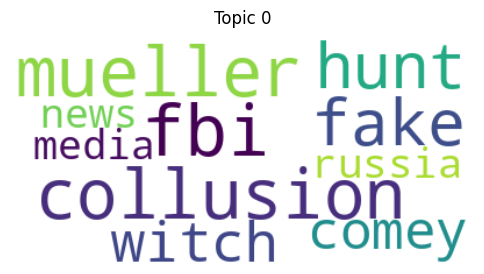

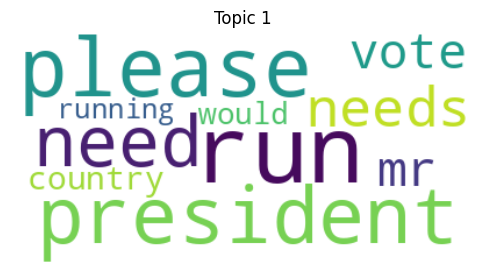

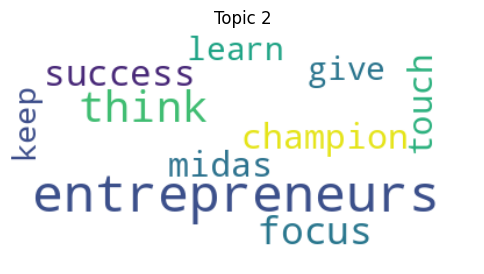

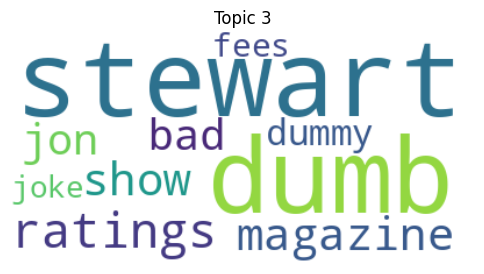

In [85]:
#visualize top three nonoutlier topics
for topic_id in sorted(set(topics_bertweet)):
    if topic_id != -1:
        plot_wordcloud(topic_model_bertweet, topic_id)
        if topic_id >= 3:
            break

Here from the **Intertopic Distance Map**, we can see how similar or different topics are from each other. Larger circles represent topics with more tweets and Smaller circles represent less frequent topics.

In [86]:
topic_model_bertweet.visualize_topics()

##**STEP 4: Create time bins for dynamic setup**

Dynamic topic modeling cannot exist without time bins.
Time bins allow BERTopic to compare topic representations across periods.

Trump’s tweets were divided into ten time steps, by splitting the full date range into ten equal-sized bins.This avoids arbitrary political assumptions, and helps maintain a balanced temporal segmentation.

In our case, increasing the number of time bins is not appropriate because the dataset is not large enough. Further splitting would result in some bins containing too few tweets, which can lead to unstable topic representations. Using more bins is only beneficial when each bin contains a sufficient number of tweets to produce reliable topics.

Here, the temporal distribution of tweets was analyzed by manually. During modeling in the next steps, BERTopic applies this binning internally through the nr_bins parameter, without requiring manual bin assignment.

In [87]:
import numpy as np

N_BINS = 10
df["time_bin"] = pd.cut(
    df["date"],
    bins=N_BINS,
    labels=list(range(N_BINS))
)
df["time_bin"] = df["time_bin"].astype(int)
print("Tweets per time bin:")
print(df["time_bin"].value_counts().sort_index())


Tweets per time bin:
time_bin
0     129
1     336
2    3197
3    7827
4    7301
5    7356
6    3230
7    3228
8    4857
9    5773
Name: count, dtype: int64


In [88]:
bin_ranges = df.groupby("time_bin")["date"].agg(["min", "max"])
bin_ranges

,min,max
time_bin,,
0,2009-05-04 18:54:25,2010-07-02 15:27:17
1,2010-07-06 14:52:14,2011-09-02 18:27:03
2,2011-09-06 16:12:36,2012-11-04 18:53:26
3,2012-11-04 22:09:04,2014-01-04 05:55:08
4,2014-01-05 16:29:42,2015-03-07 02:00:08
5,2015-03-08 11:12:22,2016-05-07 17:46:46
6,2016-05-08 01:29:54,2017-07-07 23:33:26
7,2017-07-08 18:17:24,2018-09-07 21:39:37
8,2018-09-08 14:44:29,2019-11-08 17:19:37


## **Step 5: Dynamic topic modeling with BERTopic**

We analyzed how the frequency of previously identified topics changes over time. The tweets are grouped into ten time bins (nr_bins=10) based on their timestamps, and topic prevalence is calculated for each bin.Global tuning was applied to keep topics consistent across different time periods, while evolution tuning was used to smooth changes between adjacent periods.


**Global tuning = True,** Global tuning makes sure that topics identified in each time period stay consistent with the overall (global) topics learned from the full dataset.


**evolution_tuning=True** means, Topic trends become smoother and easier to interpret
and Topic words are allowed to change slightly between time periods. Sudden, noisy changes are reduced. It avoids sharp fluctuations caused by small or noisy time bins.



In [89]:
#generate topics over time
topics_over_time = topic_model_bertweet.topics_over_time(
    docs=tweets,
    timestamps=timestamps,
    nr_bins=10,              #same number of bins as step 4
    global_tuning=True,      #align local topics with global topics
    evolution_tuning=True  #smoothing on
)


10it [00:03,  3.10it/s]


In [90]:
#inspect the dynamic output
topics_over_time = topics_over_time[topics_over_time["Topic"] != -1]
topics_over_time.head(20)


,Topic,Words,Frequency,Timestamp
1,1,"precipice, something, could, always, know",1,2009-04-30 12:30:07.597
2,2,"execute, imagination, wholeness, inexplicable,...",6,2009-04-30 12:30:07.597
3,6,"hysterical, sweepstakes, dsrl, browse, lick",5,2009-04-30 12:30:07.597
4,15,"course, tngc, scotland, bluffs, dunes",3,2009-04-30 12:30:07.597
5,18,"bret, fanastic, medalist, lysacek, evan",2,2009-04-30 12:30:07.597
6,19,"ride, covers, wsj, fame, via",1,2009-04-30 12:30:07.597
7,28,"geomorphology, landforms, paperback, bestselli...",2,2009-04-30 12:30:07.597
8,29,"celebrity, nbc, apprentice, sunday, tune",7,2009-04-30 12:30:07.597
9,30,"wishing, memorial, freedom, veterans, weekend",1,2009-04-30 12:30:07.597
10,39,"soho, hotel, downtown, opens, fantastic",2,2009-04-30 12:30:07.597


**Result:** In early time periods, topic frequencies are low and many topics appear only once, **(e.g. in Topic24, frequency =1)** which limits the reliability of temporal trends. However, several topics remain semantically coherent, such as media-related and travel-related topics, indicating that the model successfully captures meaningful themes despite sparse data in early bins. e.g. **Topic 40 =  nbc, celebrity, sunday, apprentice, casting** can be considered as TV or Media appearances.
**Topic 9 = awards, habitat, travel, leisure, urban** can be considered as travel and lifestyle.


### **Normalized Topic Trends**
We normalized topic frequencies by dividing each topic’s count by the total number of tweets in each time period. This allows topic trends to be compared fairly over time, even when the number of tweets varies between periods.

In [91]:
#normalize topic frequencies
topics_over_time["Normalized_Frequency"] = (
    topics_over_time["Frequency"] /
    topics_over_time.groupby("Timestamp")["Frequency"].transform("sum")
)

In this step, we measured how each topic changes over time. For every topic, we calculated the difference between its normalized frequency in the first time period and its normalized frequency in the last time period. A positive value means the topic becomes more important over time, while a negative value means the topic becomes less important.

In [92]:
topic_trends = (
    topics_over_time
    .groupby("Topic")
    .apply(lambda x: x.sort_values("Timestamp")["Normalized_Frequency"].iloc[-1]
                    - x.sort_values("Timestamp")["Normalized_Frequency"].iloc[0])
    .reset_index(name="Trend_Score")
)

topic_trends.sort_values("Trend_Score", ascending=False).head(10)

/tmp/ipython-input-3853841431.py:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,Topic,Trend_Score
0,0,0.220997
13,13,0.076130
16,16,0.061510
72,72,0.034664
42,42,0.026310
56,56,0.023912
50,50,0.021554
44,44,0.015182
78,78,0.013066
20,20,0.012057


**Result:** From the output, we can see, topic 0 has the highest trend score (**0.1077**).This topic shows the strongest growth over time and can be considered an emerging or increasingly discussed topic. Topics 10 and 12 also increased, but much less than Topic 0. These topics show moderate growth. However, some values here are very close to zero.Value close to zero means very small change.

### **Focus on Meaningful Topics Only**
We selected only meaningful topics for the dynamic analysis. Topics labeled as outliers were removed, and only topics with more than 200 tweets were kept. This helps focus the analysis on topics that appear frequently enough to show reliable trends over time

In [94]:
meaningful_topics = topic_info[
    (topic_info["Topic"] != -1) &
    (topic_info["Count"] > 200)
]["Topic"].tolist()

topics_over_time_filtered = topics_over_time[
    topics_over_time["Topic"].isin(meaningful_topics)
]

In [95]:
topic_model_bertweet.visualize_topics_over_time(
    topics_over_time_filtered,
    top_n_topics=8
)

**Result:** Graph shows how the frequency of selected topics changes over time, with each colored line representing a different topic. For example, the topic related to the FBI, collusion, and Mueller investigations increases sharply in the middle of the timeline, reflecting periods of heightened public discussion. Topics associated with entrepreneurship and motivation appear more frequently in the earlier years and gradually decline over time. In contrast, election-related topics rise and fall around election periods, demonstrating clear temporal patterns linked to real-world political event.

### **Track Keyword Stability Over Time**
This part we extracted the keywords of a selected topic across different time periods. It allows us to examine whether the meaning of a topic remains stable over time by comparing its keywords at each time bin.

In [96]:
def keyword_change_over_time(topics_over_time, topic_id):
    return (
        topics_over_time[topics_over_time["Topic"] == topic_id]
        .sort_values("Timestamp")[["Timestamp", "Words"]]
    )

In [97]:
topic_info = topic_model_bertweet.get_topic_info()
topic_info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,23934,-1_great_trump_obama_people,"[great, trump, obama, people, amp, would, good...",[thank you wisconsin get out and vote together...
1,0,2153,0_fbi_collusion_mueller_fake,"[fbi, collusion, mueller, fake, hunt, witch, c...",[robert mueller is being asked to testify yet ...
2,1,1572,1_run_please_president_need,"[run, please, president, need, needs, mr, vote...","[so can u run please be our president, please ..."
3,2,1007,2_entrepreneurs_think_focus_success,"[entrepreneurs, think, focus, success, champio...","[keep your focus and never give up, entreprene..."
4,3,575,3_stewart_dumb_ratings_magazine,"[stewart, dumb, ratings, magazine, show, jon, ...",[magazine is doing so poorly that they make ev...
...,...,...,...,...,...
271,270,10,270_legend_pilots_maker_dummies,"[legend, pilots, maker, dummies, ray, idol, ch...","[you are a king maker don true, you re a legen..."
272,271,10,271_patriots_evening_beautiful_fresno,"[patriots, evening, beautiful, fresno, magaral...",[beautiful evening in mesa arizona with great ...
273,272,10,272_secretary_mcmaster_director_advisor,"[secretary, mcmaster, director, advisor, congr...",[briefing with director marc short and directo...
274,273,10,273_japan_abe_prime_minister,"[japan, abe, prime, minister, korea, playef, r...",[after two days of very productive talks prime...


In [98]:
TOPIC_ID = 160 # election related topic

df_keywords = keyword_change_over_time(
    topics_over_time,
    TOPIC_ID
)

df_keywords["Words"] = df_keywords["Words"].apply(
    lambda x: ", ".join(x.split(",")[:10])
)

df_keywords

,Timestamp,Words
300,2012-11-04 20:21:25.900,"vote, thanks, definately, vindicated, got"
480,2014-01-05 12:50:26.200,"vote, definately, got, vindicated, definitely"
665,2015-03-08 05:19:26.500,"vote, got, definitely, voted, mark"
1114,2018-09-08 06:46:27.400,"vindicated, vote, totally, definately, got"


**Result:** From the output we can see that, The topic 160 is election related topic and it is consistently about White House press conferences. If I break into more details:

**2016-05-07:** eleventh, conference, january, general, white

**2017-07-08:** omnibus, conference, concerning, white, house

**2018-09-08** white, live, house, conference, press
conference

**2019-11-08** conference, white, press, house, eastern

So we can see words like white,house,press etc. appear again and again from 2016 to 2019.

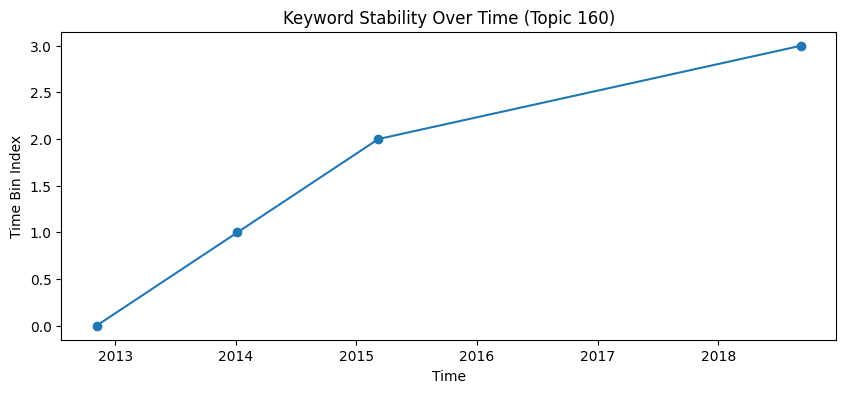

In [99]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(df_keywords["Timestamp"], range(len(df_keywords)), marker="o")
plt.title("Keyword Stability Over Time (Topic {})".format(TOPIC_ID))
plt.xlabel("Time")
plt.ylabel("Time Bin Index")
plt.show()

**Result:** The plot shows that Topic 160 appears consistently across multiple time periods, indicating that it is a persistent topic rather than a short-lived event.

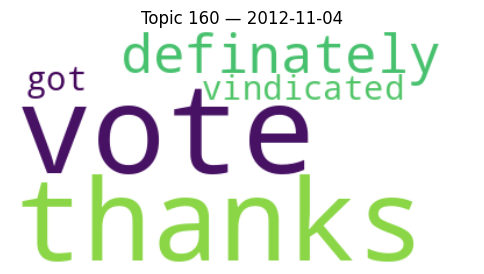

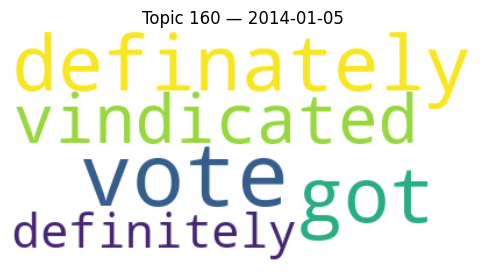

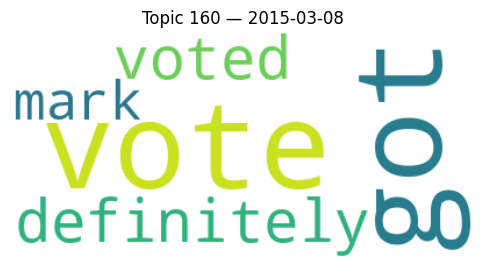

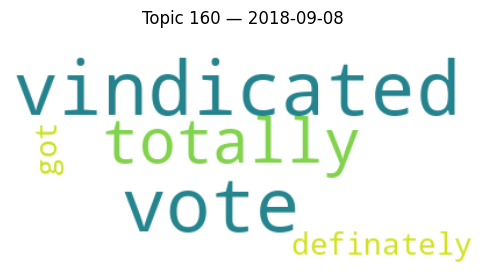

In [100]:
#showing first four timebin in wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_dynamic_wordcloud(topics_over_time, topic_id, timestamp):
    row = topics_over_time[
        (topics_over_time["Topic"] == topic_id) &
        (topics_over_time["Timestamp"] == timestamp)
    ]
    if row.empty:
        print("No data for this topic at this time.")
        return
    words = row.iloc[0]["Words"]
    word_freq = {w.strip(): 1 for w in words.split(",")}

    wc = WordCloud(
        background_color="white",
        max_words=100
    ).generate_from_frequencies(word_freq)

    plt.figure(figsize=(6, 4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {topic_id} — {timestamp.date()}")
    plt.show()
TOPIC_ID = 160
timestamps_for_topic = (
    topics_over_time[topics_over_time["Topic"] == TOPIC_ID]
    .sort_values("Timestamp")["Timestamp"]
    .unique()
)
for ts in timestamps_for_topic[:4]:
    plot_dynamic_wordcloud(topics_over_time, TOPIC_ID, ts)

## **Step 6: Classical Topic Modelling with LDA(Latent Dirichlet Allocation)**



We implemented LDA using a Bag-of-Words representation and extracted the top keywords for each topic

In [101]:
#vectorization (bag-of-words)
#train LDA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

lda_vectorizer = CountVectorizer(
    stop_words="english",
    min_df=10,
    max_df=0.9
)

X_lda = lda_vectorizer.fit_transform(tweets)

lda = LatentDirichletAllocation(
    n_components=10,
    random_state=42
)

lda.fit(X_lda)



LatentDirichletAllocation(random_state=42)

In [102]:
#create tokenized texts from your existing tweets
texts = [tweet.split() for tweet in tweets]


In [103]:
#create gensim dictionary and corpus
import gensim.corpora as corpora

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [104]:
def display_lda_topics(model, feature_names, n_top_words=10):
    for idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[-n_top_words:][::-1]
        words = [feature_names[i] for i in top_indices]
        print(f"Topic {idx}: {', '.join(words)}")

display_lda_topics(lda, lda_vectorizer.get_feature_names_out())

Topic 0: amp, border, country, strong, great, people, military, american, vote, total
Topic 1: thank, great, big, tonight, house, win, night, today, state, new
Topic 2: china, great, forward, united, states, happy, trade, looking, today, president
Topic 3: news, fake, media, amp, just, people, election, bad, like, don
Topic 4: hillary, president, democrats, clinton, amp, crooked, said, did, people, just
Topic 5: obama, amp, deal, obamacare, iran, cont, big, stay, attack, debt
Topic 6: like, great, don, people, think, just, new, book, know, really
Topic 7: trump, best, great, new, golf, course, world, amp, amazing, thank
Topic 8: trump, president, donald, thanks, run, thank, mr, great, vote, love
Topic 9: great, america, make, job, amp, jobs, interview, doing, work, time


# **Part 2: Evaluation**

## **Topic Coherence & Topic Diversity for BerTopic - Static Model**
We calculate Topic Coherence (TC) and Topic Diversity (TD) only for the static BERTopic model(Step 2). Dynamic topic modeling does not create new topics. Topic words are aligned to the  static topics. So recalculating coherence per time slice would be unstable as there are few documents per bin.

In [105]:
import pandas as pd
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence(topic_model, topics, texts):
    """Compute c_v topic coherence for a BERTopic model"""


    docs = pd.DataFrame({
        "Document": texts,
        "Topic": topics
    })


    docs_per_topic = docs.groupby(
        "Topic", as_index=False
    ).agg({"Document": " ".join})


    cleaned_docs = topic_model._preprocess_text(
        docs_per_topic.Document.values
    )


    vectorizer = topic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()

    tokens = [analyzer(doc) for doc in cleaned_docs]


    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]


    topic_words = [
        [word for word, _ in topic_model.get_topic(topic)]
        for topic in set(topics)
        if topic != -1
    ]
    coherence_model = CoherenceModel(
        topics=topic_words,
        texts=tokens,
        corpus=corpus,
        dictionary=dictionary,
        coherence="c_v"
    )

    return coherence_model.get_coherence()


In [106]:
from gensim.models.coherencemodel import CoherenceModel

coherence_bertweet = compute_coherence(
    topic_model_bertweet, topics_bertweet, tweets
)

In [107]:
def topic_diversity(topic_model, top_k=25):
    all_words = []

    for topic in topic_model.get_topic_info()["Topic"]:
        if topic == -1:
            continue
        words = topic_model.get_topic(topic)
        if words:
            all_words.extend([w for w, _ in words[:top_k]])

    return len(set(all_words)) / len(all_words)
div_bertweet = topic_diversity(topic_model_bertweet)

In [108]:
print("BERTweet Topic Coherence:", coherence_bertweet)
print("BERTweet topic diversity:", div_bertweet)

BERTweet Topic Coherence: 0.6160024769784759
BERTweet topic diversity: 0.7098181818181818


## **Topic Coherence & Topic Diversity for LDA**

In [110]:
#extract LDA topics as word lists
lda_topics = []

feature_names = lda_vectorizer.get_feature_names_out()

for topic in lda.components_:
    top_indices = topic.argsort()[-10:][::-1]  # top 10 words
    lda_topics.append([feature_names[i] for i in top_indices])


In [111]:
from gensim.models.coherencemodel import CoherenceModel

lda_coherence_model = CoherenceModel(
    topics=lda_topics,
    texts=texts,
    dictionary=dictionary,
    coherence='c_v'
)

lda_tc = lda_coherence_model.get_coherence()

def topic_diversity(topics):
    all_words = [word for topic in topics for word in topic]
    unique_words = set(all_words)
    return len(unique_words) / len(all_words)

lda_td = topic_diversity(lda_topics)



print("LDA Topic Coherence (TC):", lda_tc)
print("LDA Topic Diversity (TD):", lda_td)

LDA Topic Coherence (TC): 0.4975391065078
LDA Topic Diversity (TD): 0.72


## **Compare BerTopic with LDA**

In [112]:
import pandas as pd

results = pd.DataFrame({
    "Model": ["BERTopic", "LDA"],
    "Topic Coherence (TC)": [coherence_bertweet, lda_tc],
    "Topic Diversity (TD)": [div_bertweet, lda_td]
})

results

,Model,Topic Coherence (TC),Topic Diversity (TD)
0,BERTopic,0.616002,0.709818
1,LDA,0.497539,0.720000


#**Model Evaluation Summary**
The results show that BERTopic achieves a higher **Topic Coherence (0.623)** compared to **LDA (0.498)**. This indicates that the topics produced by BERTopic are more semantically meaningful and that the top words within each topic are more closely related to each other. This improvement is expected, as BERTopic uses contextual embeddings, which better capture the semantic structure of tweets.

In terms of **Topic Diversity**, both models perform similarly, with **LDA (0.72)** slightly higher than **BERTopic (0.716)**. This suggests that both models generate a comparable level of vocabulary diversity across topics, although LDA spreads words more evenly across topics due to its bag-of-words nature.

Overall, BERTopic produces clearer and more meaningful topics, while LDA uses a wider variety of words across topics. This shows that BERTopic focuses more on topic meaning, whereas LDA covers more words but with less clear meaning.


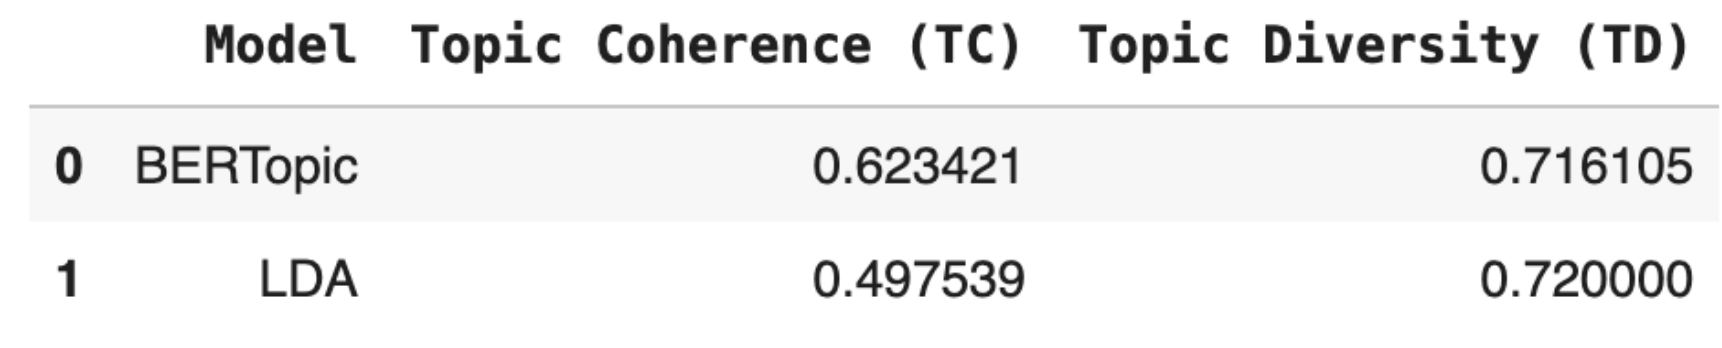

## Extra

1. **Does the Data Processing Step Matter for Good Results?**
- Yes, we followed the preprocessing steps suggested in the paper and also included some additional steps. Proper data preprocessing is important for achieving better topic modeling results.

2. **Does BERTweet model produce good topics compared to other models?**
 - Yes
3. **Does the choice of embedding model matter?**
 - Yes, the choice of the embedding model and parameter settings matters for achieving good topic coherence (TC) and topic diversity (TD) scores.